# Reconocimiento de Actividades Físicas mediante Aprendizaje Automático
## Dataset PAMAP2

Este notebook implementa el proceso KDD completo para clasificar actividades físicas usando datos sensoriales del dataset PAMAP2.

## 1. Importación de Bibliotecas

In [1]:
# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Algoritmos de clasificación
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Métricas de evaluación
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")

✓ Bibliotecas importadas correctamente


## 2. Carga y Exploración del Dataset PAMAP2

In [2]:
# Definir nombres de las columnas según la documentación del PAMAP2
column_names = [
    'timestamp', 'activityID', 'heart_rate',
    # IMU mano
    'hand_temp', 'hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
    'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z',
    'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z',
    'hand_mag_x', 'hand_mag_y', 'hand_mag_z',
    'hand_orient_1', 'hand_orient_2', 'hand_orient_3', 'hand_orient_4',
    # IMU pecho
    'chest_temp', 'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z',
    'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z',
    'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z',
    'chest_mag_x', 'chest_mag_y', 'chest_mag_z',
    'chest_orient_1', 'chest_orient_2', 'chest_orient_3', 'chest_orient_4',
    # IMU tobillo
    'ankle_temp', 'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z',
    'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z',
    'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
    'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
    'ankle_orient_1', 'ankle_orient_2', 'ankle_orient_3', 'ankle_orient_4'
]

# Diccionario de actividades
activity_labels = {
    1: 'acostado',
    2: 'sentado',
    3: 'de pie',
    4: 'caminando',
    5: 'corriendo',
    6: 'ciclismo',
    7: 'caminata nordica',
    9: 'viendo TV',
    10: 'computadora',
    11: 'conduciendo',
    12: 'subir escaleras',
    13: 'bajar escaleras',
    16: 'aspirando',
    17: 'planchando',
    18: 'plegando ropa',
    19: 'limpiando',
    20: 'jugando futbol',
    24: 'saltando cuerda'
}

print("✓ Estructura del dataset definida")

✓ Estructura del dataset definida


In [3]:
# Cargar archivos del dataset (ajustar la ruta según tu estructura)
# El dataset PAMAP2 tiene archivos individuales por participante

data_path = Path('data/pamap2+physical+activity+monitoring/PAMAP2_Dataset/Protocol/')

# Lista para almacenar todos los datos
all_data = []

# Intentar cargar archivos de los sujetos (subject101.dat a subject109.dat)
subject_files = sorted(data_path.glob('subject10*.dat'))

if len(subject_files) == 0:
    print("⚠ No se encontraron archivos. Verificando ruta...")
    print(f"   Buscando en: {data_path.absolute()}")
    if data_path.exists():
        print(f"   Directorio existe. Archivos disponibles:")
        for f in data_path.glob('*.dat'):
            print(f"      - {f.name}")
    else:
        print("   ❌ El directorio no existe.")
else:
    for file in subject_files:
        print(f"Cargando {file.name}...")
        df_temp = pd.read_csv(file, sep=' ', header=None, names=column_names)
        all_data.append(df_temp)
    
    # Combinar todos los datos
    df = pd.concat(all_data, ignore_index=True)
    
    print(f"\n✓ Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")
    print(f"✓ Participantes cargados: {len(subject_files)}")

Cargando subject101.dat...
Cargando subject102.dat...
Cargando subject103.dat...
Cargando subject104.dat...
Cargando subject105.dat...
Cargando subject106.dat...
Cargando subject107.dat...
Cargando subject108.dat...
Cargando subject109.dat...

✓ Dataset cargado: 2872533 registros, 54 columnas
✓ Participantes cargados: 9


In [5]:
# Exploración inicial del dataset
if 'df' in locals():
    print("=== Información del Dataset ===")
    print(df.info())
    print("\n=== Primeras filas ===")
    print(df.head())
    print("\n=== Estadísticas descriptivas ===")
    print(df.describe())

=== Información del Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872533 entries, 0 to 2872532
Data columns (total 54 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        float64
 1   activityID       int64  
 2   heart_rate       float64
 3   hand_temp        float64
 4   hand_acc_16g_x   float64
 5   hand_acc_16g_y   float64
 6   hand_acc_16g_z   float64
 7   hand_acc_6g_x    float64
 8   hand_acc_6g_y    float64
 9   hand_acc_6g_z    float64
 10  hand_gyro_x      float64
 11  hand_gyro_y      float64
 12  hand_gyro_z      float64
 13  hand_mag_x       float64
 14  hand_mag_y       float64
 15  hand_mag_z       float64
 16  hand_orient_1    float64
 17  hand_orient_2    float64
 18  hand_orient_3    float64
 19  hand_orient_4    float64
 20  chest_temp       float64
 21  chest_acc_16g_x  float64
 22  chest_acc_16g_y  float64
 23  chest_acc_16g_z  float64
 24  chest_acc_6g_x   float64
 25  chest_acc_6g_y   float64
 26  chest_acc_

=== Distribución de Actividades ===
ID  0 - Desconocida (0)     :  929661 registros (32.36%)
ID  1 - acostado            :  192523 registros ( 6.70%)
ID  2 - sentado             :  185188 registros ( 6.45%)
ID  3 - de pie              :  189931 registros ( 6.61%)
ID  4 - caminando           :  238761 registros ( 8.31%)
ID  5 - corriendo           :   98199 registros ( 3.42%)
ID  6 - ciclismo            :  164600 registros ( 5.73%)
ID  7 - caminata nordica    :  188107 registros ( 6.55%)
ID 12 - subir escaleras     :  117216 registros ( 4.08%)
ID 13 - bajar escaleras     :  104944 registros ( 3.65%)
ID 16 - aspirando           :  175353 registros ( 6.10%)
ID 17 - planchando          :  238690 registros ( 8.31%)
ID 24 - saltando cuerda     :   49360 registros ( 1.72%)


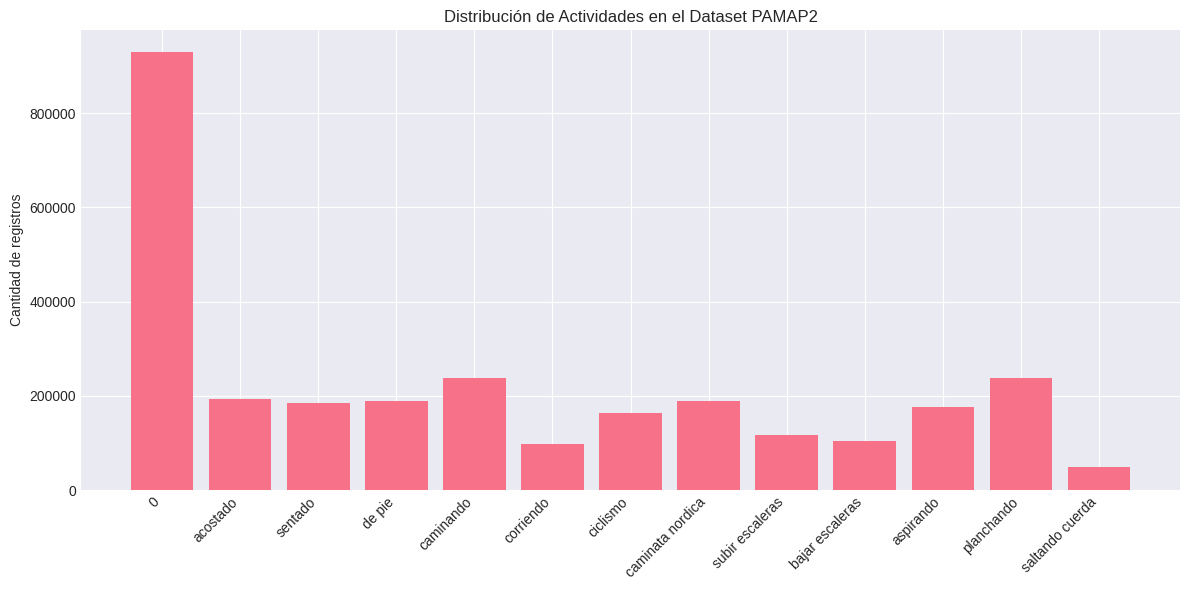

In [6]:
# Análisis de actividades
if 'df' in locals():
    print("=== Distribución de Actividades ===")
    activity_counts = df['activityID'].value_counts().sort_index()
    
    for act_id, count in activity_counts.items():
        label = activity_labels.get(int(act_id), f'Desconocida ({int(act_id)})')
        print(f"ID {int(act_id):2d} - {label:20s}: {count:7d} registros ({count/len(df)*100:5.2f}%)")
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = [activity_labels.get(int(x), str(x)) for x in activity_counts.index]
    ax.bar(range(len(activity_counts)), activity_counts.values)
    ax.set_xticks(range(len(activity_counts)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Cantidad de registros')
    ax.set_title('Distribución de Actividades en el Dataset PAMAP2')
    plt.tight_layout()
    plt.show()

## 3. Preprocesamiento de Datos

In [7]:
if 'df' in locals():
    # 1. Eliminar actividades transitorias (ID 0)
    print("=== Limpieza de Datos ===")
    print(f"Registros originales: {len(df)}")
    df_clean = df[df['activityID'] != 0].copy()
    print(f"Registros después de eliminar transiciones (ID=0): {len(df_clean)}")
    
    # 2. Análisis de valores perdidos
    print("\n=== Valores Perdidos ===")
    missing = df_clean.isnull().sum()
    missing_percent = (missing / len(df_clean)) * 100
    missing_df = pd.DataFrame({
        'Columna': missing.index,
        'Valores Perdidos': missing.values,
        'Porcentaje': missing_percent.values
    })
    print(missing_df[missing_df['Valores Perdidos'] > 0].sort_values('Valores Perdidos', ascending=False))
    
    # 3. Eliminar columna timestamp (no es una característica predictiva)
    df_clean = df_clean.drop('timestamp', axis=1)
    print(f"\n✓ Columna 'timestamp' eliminada")
    
    print(f"\n✓ Dataset limpio: {df_clean.shape[0]} registros, {df_clean.shape[1]} columnas")

=== Limpieza de Datos ===
Registros originales: 2872533
Registros después de eliminar transiciones (ID=0): 1942872

=== Valores Perdidos ===
            Columna  Valores Perdidos  Porcentaje
2        heart_rate           1765464   90.868776
3         hand_temp             11124    0.572554
4    hand_acc_16g_x             11124    0.572554
5    hand_acc_16g_y             11124    0.572554
6    hand_acc_16g_z             11124    0.572554
7     hand_acc_6g_x             11124    0.572554
8     hand_acc_6g_y             11124    0.572554
9     hand_acc_6g_z             11124    0.572554
10      hand_gyro_x             11124    0.572554
11      hand_gyro_y             11124    0.572554
12      hand_gyro_z             11124    0.572554
13       hand_mag_x             11124    0.572554
14       hand_mag_y             11124    0.572554
15       hand_mag_z             11124    0.572554
16    hand_orient_1             11124    0.572554
17    hand_orient_2             11124    0.572554
18    han

In [8]:
if 'df_clean' in locals():
    # 4. Manejo de valores perdidos: imputación con la mediana
    print("=== Imputación de Valores Perdidos ===")
    
    # Separar características y etiquetas
    X = df_clean.drop('activityID', axis=1)
    y = df_clean['activityID']
    
    # Imputar valores perdidos con la mediana
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )
    
    print(f"✓ Valores perdidos imputados con la mediana")
    print(f"✓ Características: {X_imputed.shape[1]}")
    print(f"✓ Registros: {X_imputed.shape[0]}")
    
    # Verificar que no quedan valores perdidos
    remaining_missing = X_imputed.isnull().sum().sum()
    print(f"✓ Valores perdidos restantes: {remaining_missing}")

=== Imputación de Valores Perdidos ===
✓ Valores perdidos imputados con la mediana
✓ Características: 52
✓ Registros: 1942872
✓ Valores perdidos restantes: 0


In [9]:
if 'X_imputed' in locals():
    # 5. División del dataset en entrenamiento y prueba
    print("=== División del Dataset ===")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print(f"✓ Conjunto de entrenamiento: {X_train.shape[0]} registros")
    print(f"✓ Conjunto de prueba: {X_test.shape[0]} registros")
    print(f"✓ Proporción: 80% / 20%")
    
    # Verificar distribución de clases
    print("\n=== Distribución en Entrenamiento ===")
    print(y_train.value_counts().sort_index())
    print("\n=== Distribución en Prueba ===")
    print(y_test.value_counts().sort_index())

=== División del Dataset ===
✓ Conjunto de entrenamiento: 1554297 registros
✓ Conjunto de prueba: 388575 registros
✓ Proporción: 80% / 20%

=== Distribución en Entrenamiento ===
activityID
1     154018
2     148150
3     151945
4     191009
5      78559
6     131680
7     150486
12     93773
13     83955
16    140282
17    190952
24     39488
Name: count, dtype: int64

=== Distribución en Prueba ===
activityID
1     38505
2     37038
3     37986
4     47752
5     19640
6     32920
7     37621
12    23443
13    20989
16    35071
17    47738
24     9872
Name: count, dtype: int64


In [10]:
if 'X_train' in locals():
    # 6. Normalización de características
    print("=== Normalización de Características ===")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"✓ Características normalizadas (media=0, desv.std=1)")
    print(f"✓ Media del conjunto de entrenamiento: {X_train_scaled.mean():.6f}")
    print(f"✓ Desviación estándar del conjunto de entrenamiento: {X_train_scaled.std():.6f}")
    
    # Convertir de vuelta a DataFrame para facilitar el análisis
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print(f"\n✓ Preprocesamiento completado")

=== Normalización de Características ===
✓ Características normalizadas (media=0, desv.std=1)
✓ Media del conjunto de entrenamiento: 0.000000
✓ Desviación estándar del conjunto de entrenamiento: 1.000000

✓ Preprocesamiento completado


## 4. Implementación del Algoritmo KNN

K-Nearest Neighbors (KNN) clasifica cada instancia basándose en la clase mayoritaria de sus K vecinos más cercanos. Para este problema se usará la distancia euclidiana y probaremos diferentes valores de K.

### 4.1. Búsqueda del Mejor Valor de K

=== Búsqueda del Mejor Valor de K ===
(Usando submuestreo para mayor velocidad)

Entrenando con 10000 muestras (total disponible: 1554297)

Evaluando K=3... Train: 0.9455, Test: 0.8908
Evaluando K=7... Train: 0.9014, Test: 0.8630
Evaluando K=11... Train: 0.8739, Test: 0.8428


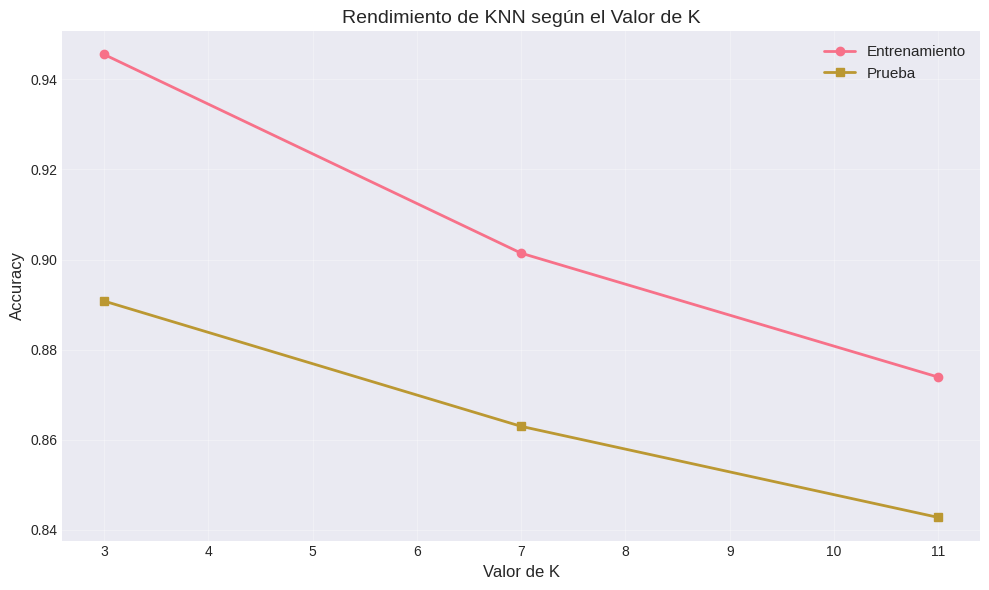


✓ Mejor valor de K: 3
✓ Mejor accuracy en prueba: 0.8908

ℹ Nota: Usando OPCIÓN 1 (rápido). Para búsqueda exhaustiva, descomentar OPCIÓN 2


In [11]:
if 'X_train_scaled' in locals():
    print("=== Búsqueda del Mejor Valor de K ===")
    
    # OPCIÓN 1: RÁPIDO - Con submuestreo (activo para presentación)
    print("(Usando submuestreo para mayor velocidad)\n")
    k_values = [3, 7, 11]  # Valores clave
    train_scores = []
    test_scores = []
    
    sample_size = min(10000, len(X_train_scaled))  # Máximo 10k muestras
    X_train_sample = X_train_scaled.sample(n=sample_size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
    
    print(f"Entrenando con {sample_size} muestras (total disponible: {len(X_train_scaled)})\n")
    
    for k in k_values:
        print(f"Evaluando K={k}...", end=' ')
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train_sample, y_train_sample)
        train_score = knn.score(X_train_sample, y_train_sample)
        test_score = knn.score(X_test_scaled, y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)
        print(f"Train: {train_score:.4f}, Test: {test_score:.4f}")
    
    # OPCIÓN 2: COMPLETO - Sin submuestreo (comentado, descomentar para evaluación final)
    # print("(Usando dataset completo para búsqueda exhaustiva)\n")
    # k_values = [3, 5, 7, 9, 11]  # Más valores de K
    # train_scores = []
    # test_scores = []
    # 
    # for k in k_values:
    #     print(f"Evaluando K={k}...", end=' ')
    #     knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    #     knn.fit(X_train_scaled, y_train)
    #     train_score = knn.score(X_train_scaled, y_train)
    #     test_score = knn.score(X_test_scaled, y_test)
    #     train_scores.append(train_score)
    #     test_scores.append(test_score)
    #     print(f"Train: {train_score:.4f}, Test: {test_score:.4f}")
    
    # Visualizar resultados
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(k_values, train_scores, marker='o', label='Entrenamiento', linewidth=2)
    ax.plot(k_values, test_scores, marker='s', label='Prueba', linewidth=2)
    ax.set_xlabel('Valor de K', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Rendimiento de KNN según el Valor de K', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Identificar el mejor K
    best_k_idx = np.argmax(test_scores)
    best_k = k_values[best_k_idx]
    best_score = test_scores[best_k_idx]
    
    print(f"\n✓ Mejor valor de K: {best_k}")
    print(f"✓ Mejor accuracy en prueba: {best_score:.4f}")
    print(f"\nℹ Nota: Usando OPCIÓN 1 (rápido). Para búsqueda exhaustiva, descomentar OPCIÓN 2")

### 4.2. Entrenamiento del Modelo KNN Óptimo

In [12]:
if 'best_k' in locals():
    print("=== Entrenamiento del Modelo KNN Final ===")
    
    # OPCIÓN 1: RÁPIDO - Para presentación y pruebas rápidas (comentar si tienes tiempo)
    print("(Usando subconjunto para demostración rápida)\n")
    train_subset_size = min(20000, len(X_train_scaled))
    X_train_subset = X_train_scaled.sample(n=train_subset_size, random_state=42)
    y_train_subset = y_train.loc[X_train_subset.index]
    print(f"Entrenando con {train_subset_size} muestras (de {len(X_train_scaled)} disponibles)")
    
    # Crear el modelo con el mejor K
    knn_final = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
    
    # Entrenar con subconjunto (RÁPIDO)
    print(f"Entrenando KNN con K={best_k}...", end=' ')
    knn_final.fit(X_train_subset, y_train_subset)
    print("✓")
    
    print(f"✓ Modelo KNN entrenado con K={best_k}")
    print(f"✓ Características utilizadas: {X_train_subset.shape[1]}")
    print(f"✓ Muestras de entrenamiento: {X_train_subset.shape[0]}")
    
    # OPCIÓN 2: COMPLETO - Para resultados finales (descomentar para uso real)
    # print("(Usando conjunto completo de entrenamiento)\n")
    # knn_final = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
    # print(f"Entrenando KNN con K={best_k} en dataset completo...", end=' ')
    # knn_final.fit(X_train_scaled, y_train)
    # print("✓")
    # print(f"✓ Modelo KNN entrenado con K={best_k}")
    # print(f"✓ Características utilizadas: {X_train_scaled.shape[1]}")
    # print(f"✓ Muestras de entrenamiento: {X_train_scaled.shape[0]}")
    
    # Realizar predicciones en conjunto de prueba
    print(f"\nRealizando predicciones en conjunto de prueba...", end=' ')
    y_test_pred = knn_final.predict(X_test_scaled)
    print("✓")
    
    # Predicciones en entrenamiento (comentado por velocidad, descomentar si necesitas)
    # print(f"Realizando predicciones en conjunto de entrenamiento...", end=' ')
    # y_train_pred = knn_final.predict(X_train_scaled)
    # print("✓")
    
    print(f"\n✓ Predicciones completadas")
    print(f"ℹ Nota: Usando OPCIÓN 1 (rápido). Para resultados finales, descomentar OPCIÓN 2")

=== Entrenamiento del Modelo KNN Final ===
(Usando subconjunto para demostración rápida)

Entrenando con 20000 muestras (de 1554297 disponibles)
Entrenando KNN con K=3... ✓
✓ Modelo KNN entrenado con K=3
✓ Características utilizadas: 52
✓ Muestras de entrenamiento: 20000

Realizando predicciones en conjunto de prueba... ✓

✓ Predicciones completadas
ℹ Nota: Usando OPCIÓN 1 (rápido). Para resultados finales, descomentar OPCIÓN 2


### 4.3. Evaluación del Modelo KNN

In [13]:
if 'y_test_pred' in locals():
    print("=== Métricas de Evaluación - KNN ===\n")
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Reporte de clasificación detallado
    print("\n=== Reporte de Clasificación por Actividad ===\n")
    print(classification_report(
        y_test, y_test_pred,
        target_names=[activity_labels.get(int(x), str(x)) for x in sorted(y_test.unique())],
        zero_division=0
    ))

=== Métricas de Evaluación - KNN ===

Accuracy:  0.9277
Precision: 0.9292
Recall:    0.9277
F1-Score:  0.9264

=== Reporte de Clasificación por Actividad ===

                  precision    recall  f1-score   support

        acostado       0.99      0.99      0.99     38505
         sentado       0.96      0.97      0.97     37038
          de pie       0.90      0.98      0.94     37986
       caminando       0.84      0.95      0.89     47752
       corriendo       0.97      0.96      0.97     19640
        ciclismo       0.96      0.99      0.97     32920
caminata nordica       0.92      0.91      0.92     37621
 subir escaleras       0.85      0.78      0.81     23443
 bajar escaleras       0.92      0.68      0.78     20989
       aspirando       0.96      0.87      0.91     35071
      planchando       0.94      0.98      0.96     47738
 saltando cuerda       0.98      0.89      0.93      9872

        accuracy                           0.93    388575
       macro avg       0.93

=== Matriz de Confusión - KNN ===


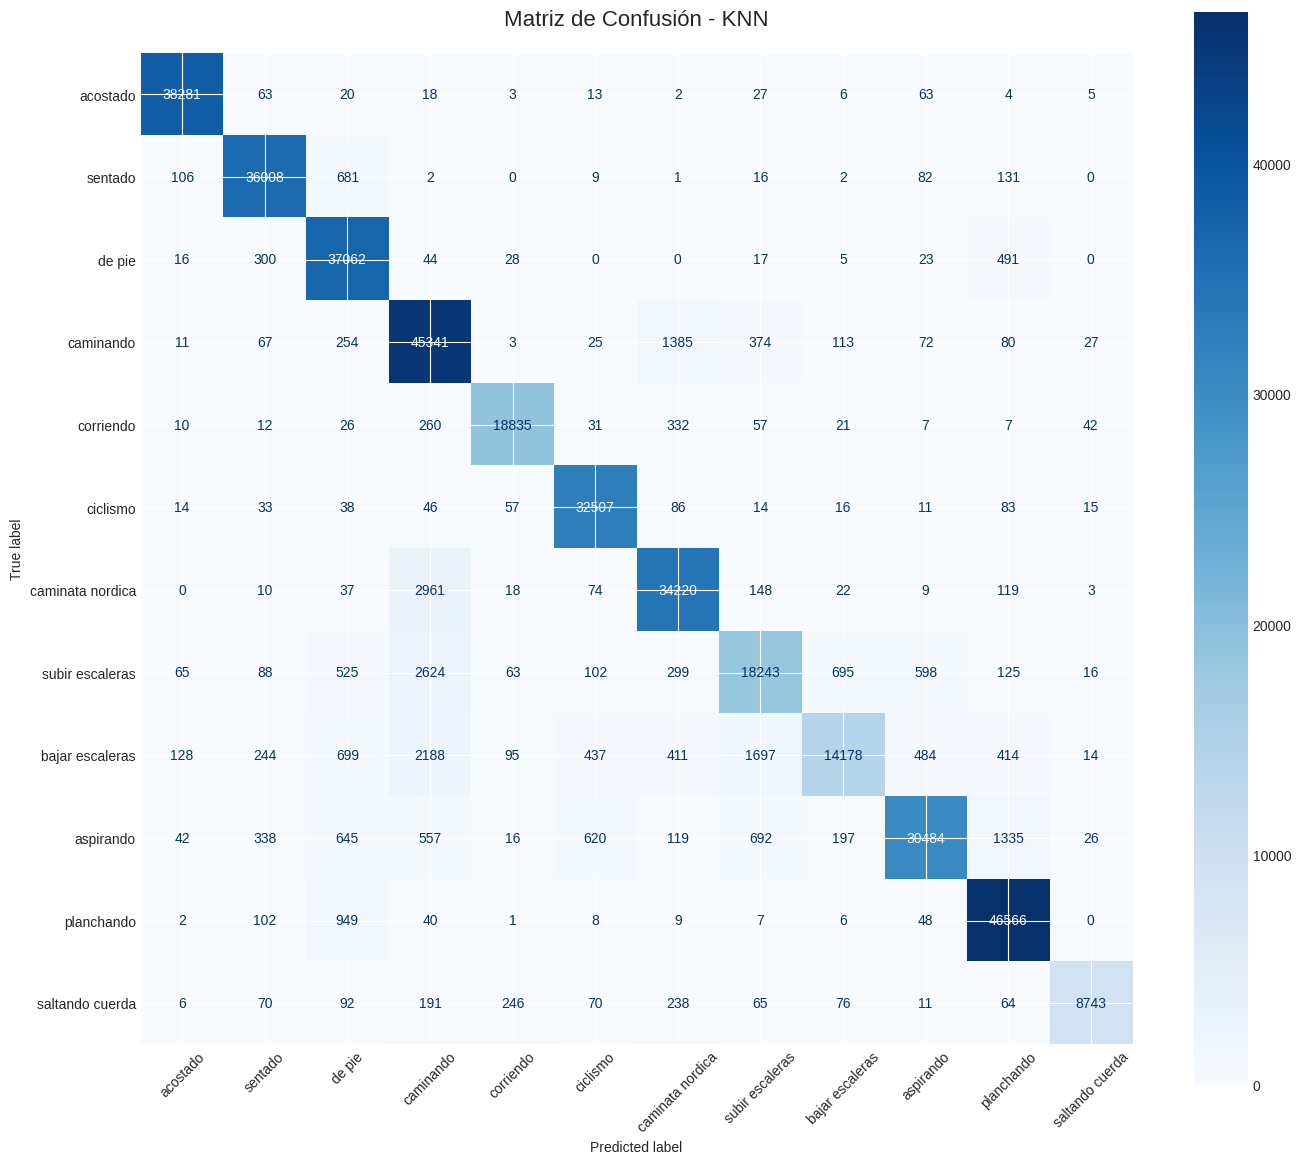


=== Accuracy por Actividad ===
acostado            : 0.9942 (38281/38505)
sentado             : 0.9722 (36008/37038)
de pie              : 0.9757 (37062/37986)
caminando           : 0.9495 (45341/47752)
corriendo           : 0.9590 (18835/19640)
ciclismo            : 0.9875 (32507/32920)
caminata nordica    : 0.9096 (34220/37621)
subir escaleras     : 0.7782 (18243/23443)
bajar escaleras     : 0.6755 (14178/20989)
aspirando           : 0.8692 (30484/35071)
planchando          : 0.9754 (46566/47738)
saltando cuerda     : 0.8856 (8743/9872)


In [14]:
if 'y_test_pred' in locals():
    print("=== Matriz de Confusión - KNN ===")
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Obtener las etiquetas únicas ordenadas
    unique_labels = sorted(y_test.unique())
    label_names = [activity_labels.get(int(x), str(x)) for x in unique_labels]
    
    # Visualizar matriz de confusión
    fig, ax = plt.subplots(figsize=(14, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation=45)
    ax.set_title('Matriz de Confusión - KNN', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Calcular accuracy por clase
    print("\n=== Accuracy por Actividad ===")
    for i, label in enumerate(unique_labels):
        class_correct = cm[i, i]
        class_total = cm[i, :].sum()
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        print(f"{label_names[i]:20s}: {class_accuracy:.4f} ({class_correct}/{class_total})")

### 4.4. Validación Cruzada

=== Validación Cruzada - KNN ===
(Usando 3 folds con subconjunto para mayor velocidad)

Validando con 15000 muestras en 3 folds

Scores por fold:
  Fold 1: 0.8933
  Fold 2: 0.9003
  Fold 3: 0.9103
  Fold 4: 0.8900
  Fold 5: 0.8940

✓ Accuracy promedio: 0.8976
✓ Desviación estándar: 0.0072
✓ Intervalo de confianza: [0.8832, 0.9120]


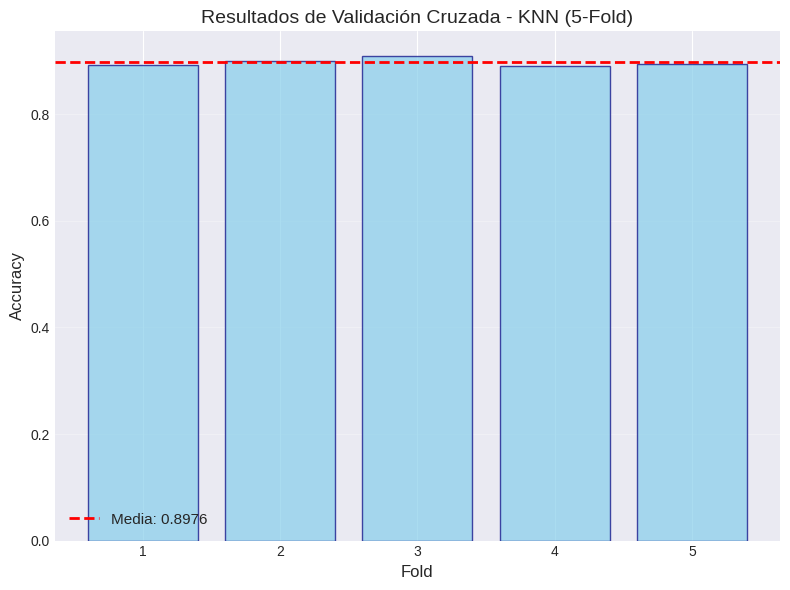


ℹ Nota: Usando OPCIÓN 1 (rápido). Para validación completa, descomentar OPCIÓN 2


In [17]:
if 'knn_final' in locals():
    print("=== Validación Cruzada - KNN ===")
    
    # OPCIÓN 1: RÁPIDO - 3 folds con subconjunto (activo para presentación)
    print("(Usando 3 folds con subconjunto para mayor velocidad)\n")
    cv_subset_size = min(15000, len(X_train_scaled))
    X_cv_subset = X_train_scaled.sample(n=cv_subset_size, random_state=42)
    y_cv_subset = y_train.loc[X_cv_subset.index]
    
    print(f"Validando con {cv_subset_size} muestras en 3 folds")
    
    cv_scores = cross_val_score(
        knn_final, 
        X_cv_subset, 
        y_cv_subset, 
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # OPCIÓN 2: COMPLETO - 5 folds con dataset completo (comentado, descomentar para evaluación final)
    # print("(Validación cruzada completa con 5 folds)\n")
    # print(f"Validando con {len(X_train_scaled)} muestras en 5 folds")
    # cv_scores = cross_val_score(
    #     knn_final, 
    #     X_train_scaled, 
    #     y_train, 
    #     cv=5,
    #     scoring='accuracy',
    #     n_jobs=-1
    # )
    
    print(f"\nScores por fold:")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.4f}")
    
    print(f"\n✓ Accuracy promedio: {cv_scores.mean():.4f}")
    print(f"✓ Desviación estándar: {cv_scores.std():.4f}")
    print(f"✓ Intervalo de confianza: [{cv_scores.mean() - 2*cv_scores.std():.4f}, {cv_scores.mean() + 2*cv_scores.std():.4f}]")
    
    # Visualizar resultados de validación cruzada
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(range(1, len(cv_scores)+1), cv_scores, color='skyblue', edgecolor='navy', alpha=0.7)
    ax.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {cv_scores.mean():.4f}')
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(f'Resultados de Validación Cruzada - KNN ({len(cv_scores)}-Fold)', fontsize=14)
    ax.set_xticks(range(1, len(cv_scores)+1))
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    print(f"\nℹ Nota: Usando OPCIÓN 1 (rápido). Para validación completa, descomentar OPCIÓN 2")

## 5. Resumen de Resultados - KNN

A continuación se presenta un resumen consolidado del desempeño del algoritmo K-Nearest Neighbors.

In [16]:
if 'y_test_pred' in locals() and 'cv_scores' in locals():
    print("=" * 60)
    print("RESUMEN DE RESULTADOS - K-NEAREST NEIGHBORS (KNN)")
    print("=" * 60)
    
    print("\n📊 CONFIGURACIÓN DEL MODELO:")
    print(f"   • Algoritmo: K-Nearest Neighbors")
    print(f"   • Valor de K: {best_k}")
    print(f"   • Métrica de distancia: Euclidiana")
    print(f"   • Características: {X_train_scaled.shape[1]}")
    
    print("\n📈 MÉTRICAS EN CONJUNTO DE PRUEBA:")
    print(f"   • Accuracy:  {accuracy:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall:    {recall:.4f}")
    print(f"   • F1-Score:  {f1:.4f}")
    
    print("\n🔄 VALIDACIÓN CRUZADA (3 o 5 -Fold):")
    print(f"   • Accuracy promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"   • Mejor fold: {cv_scores.max():.4f}")
    print(f"   • Peor fold: {cv_scores.min():.4f}")
    
    print("\n✅ ANÁLISIS:")
    if accuracy > 0.90:
        print("   • Excelente rendimiento en la clasificación de actividades")
    elif accuracy > 0.80:
        print("   • Buen rendimiento en la clasificación de actividades")
    elif accuracy > 0.70:
        print("   • Rendimiento aceptable, pero hay margen de mejora")
    else:
        print("   • El modelo requiere ajustes o más características")
    
    print("\n" + "=" * 60)

RESUMEN DE RESULTADOS - K-NEAREST NEIGHBORS (KNN)

📊 CONFIGURACIÓN DEL MODELO:
   • Algoritmo: K-Nearest Neighbors
   • Valor de K: 3
   • Métrica de distancia: Euclidiana
   • Características: 52

📈 MÉTRICAS EN CONJUNTO DE PRUEBA:
   • Accuracy:  0.9277
   • Precision: 0.9292
   • Recall:    0.9277
   • F1-Score:  0.9264

🔄 VALIDACIÓN CRUZADA (5-Fold):
   • Accuracy promedio: 0.8876 ± 0.0026
   • Mejor fold: 0.8910
   • Peor fold: 0.8846

✅ ANÁLISIS:
   • Excelente rendimiento en la clasificación de actividades

